In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from functions import Schroedinger_Equation

In [2]:
SG_base = Schroedinger_Equation()

interactive(children=(IntSlider(value=0, description='time', max=399), Output()), _dom_classes=('widget-intera…

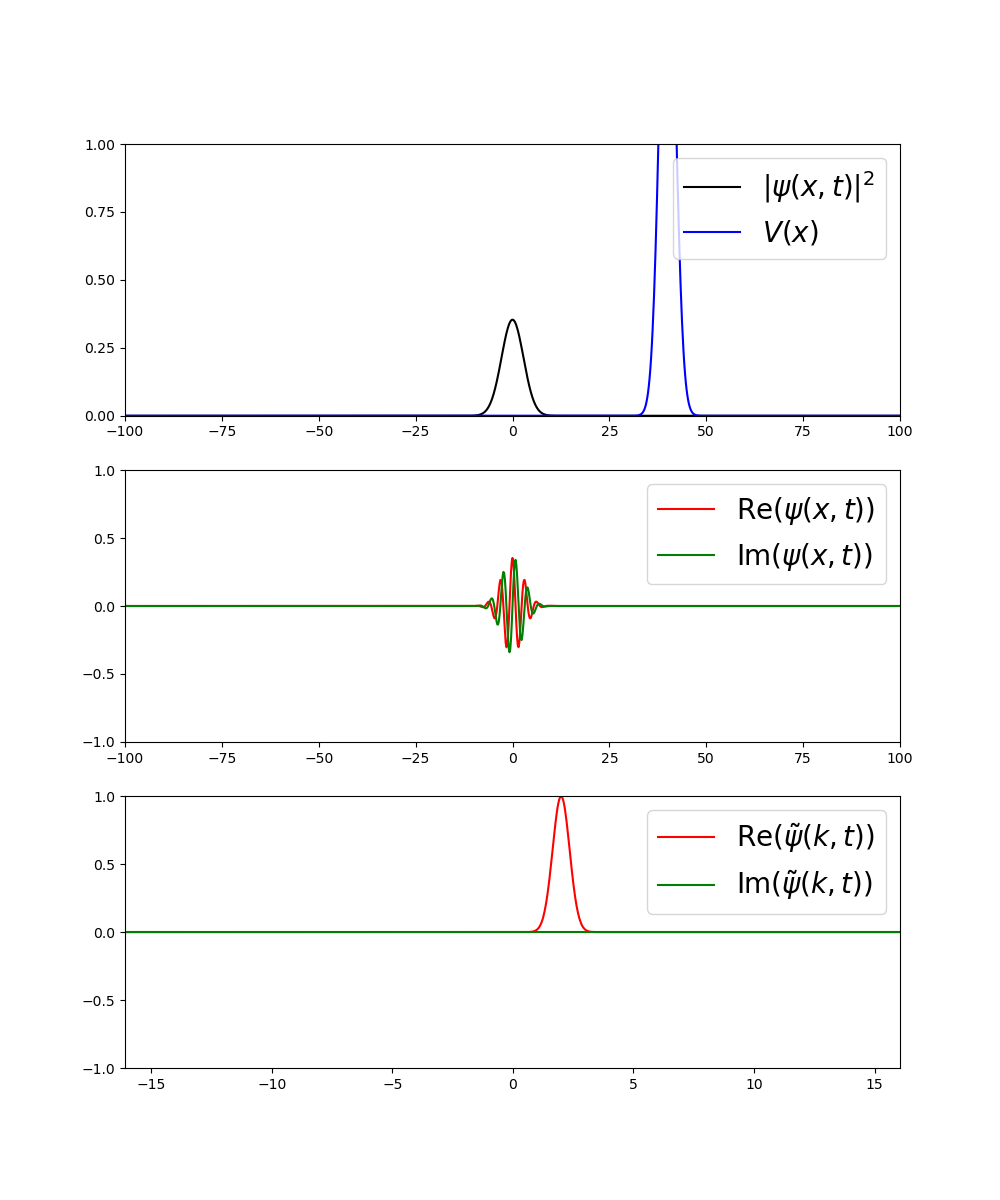

In [3]:
SG_base.solve('Barriere', v0 = 2)

# Schritt für Schritt Berechnung der Animation

In [4]:
hbar = 1
m = 1

### Initialisierung der diskreten 1D Koordinatensysteme

In [5]:
t_min = 0
t_max = 200
Nt = 400
dt = (t_max-t_min)/(Nt)
t_grid = np.arange(t_min,t_max,dt)

In [6]:
x_min = -100
x_max = 100
Nx = 2**10
dx = (x_max-x_min)/(Nx)
x_grid = np.arange(x_min,x_max,dx)

.

In [7]:
Nk = Nx
dk = 2*np.pi/(x_max-x_min)
k_grid = np.arange(-dk*Nx/2,dk*Nx/2,dk)

### Definition der diskreten Fourier-Transformation

Die diskrete Fourier-Transformation
$\tilde{\Psi}(k_{j}) = \frac{dx}{\sqrt{2\pi}}\sum_{i}e^{-ik_jx_i} \Psi(x_{i}) $ 
und ihre Inverse

wird mithilfe einer Matrix-Vektor Multiplikation der Form

$
\begin{pmatrix}\tilde{\Psi}(k_1) \\ : \\ \tilde{\Psi}(k_N) \end{pmatrix} = 
\begin{pmatrix}\frac{dx}{\sqrt{2\pi}}e^{-ik_1x_1} & .. & \frac{dx}{\sqrt{2\pi}}e^{-ik_1x_N} \\ 
: & & : \\
\frac{dx}{\sqrt{2\pi}}e^{-ik_Nx_1} & .. & \frac{dx}{\sqrt{2\pi}}e^{-ik_Nx_N} \end{pmatrix}
\begin{pmatrix}\Psi(x_1) \\ : \\ \Psi(x_N) \end{pmatrix}
$

berechnet. Analog wird die inverse diskrete Fourier-Transformation 
$\Psi(x_{j}) = \frac{dx}{\sqrt{2\pi}}\sum_{i}e^{ik_ix_j} \tilde{\Psi}(k_{i}) $ 
durchgeführt.

In [8]:
discrete_fourier_trafo_setup = np.zeros((Nk,Nx),dtype=complex)
for i in range(0,Nk):
    for j in range(0,Nx):
        discrete_fourier_trafo_setup[i,j] = dx / np.sqrt(2*np.pi) * np.exp(-1j*k_grid[i]*x_grid[j]) # Die imaginare Einheit i wird in Python mit j bezeichnet

In [9]:
def discrete_fourier_trafo(psi_x):
    psi_k = discrete_fourier_trafo_setup @ psi_x # Matrix-Vektor Multiplikation
    return psi_k

In [10]:
inv_discrete_fourier_trafo_setup = np.zeros((Nx,Nk),dtype=complex)
for j in range(0,Nx):
    for i in range(0,Nk):
        inv_discrete_fourier_trafo_setup[j,i] = dk / np.sqrt(2*np.pi) * np.exp(1j*k_grid[i]*x_grid[j])

In [11]:
def inv_discrete_fourier_trafo(psi_k):
    psi_x = inv_discrete_fourier_trafo_setup @ psi_k # Matrix-Vektor Multiplikation
    return psi_x

### Wellenfunktion initialisieren

Die Wellenfunktion im Impulsraum zum Zeitpunkt $t=0$ wird als das Gaußsche Wellenpaket

$\tilde{\Psi}(k)= e^{-(k-k_0)^2/d^2}$

definiert, und die Wellenfunktion im Ortsraum zum Zeitpunkt $t=0$ wird mithilfe der inversen diskreten Fourier-Transformation berechnet.
Hierbei gibt $k_0$ den Mittelwert und $d$ die Breite des Wellenpaketes an.

In [36]:
k0 = 2
d = 2
psi_k = np.zeros((Nt,Nx),dtype=complex)
psi_x = np.zeros((Nt,Nx),dtype=complex)

In [37]:
psi_k[0] = np.exp( -(k_grid-k0)**2 * d**2 ) * d * np.sqrt(2/np.pi) #Is * instead of / as indicated in the readme, normalization added
psi_x[0] = inv_discrete_fourier_trafo(psi_k[0])

### Potential initialisieren

Die Potentialbarriere wird als gaußsche Glockenkurve der Form

$V(x)= v_0  e^{-(x-x_0)^2/b^2}$

definiert, wobei v0 das Potential am Maximum angibt, x0 die Position des Maximums und b die Breite der Barriere.

In [38]:
v0 = 2
x0 = 40
b = 2

In [39]:
potential = v0 * np.exp(-0.5 * (x_grid-x0)**2 / b**2)

### Zeitentwicklung

Zu jedem Zeitschritt wird die Zeitentwicklung der Wellenfunktion mithilfe der Split-Operator Methode berechnet.

Dabei wird zuerst die Wirkung von $e^{-\frac{i}{\hbar}\frac{\hat{T}}{2}\Delta t}$ im Impulsraum berechnet:

$\tilde{\Psi}_{Schritt 1}(k,t) = e^{-\frac{i}{\hbar}\frac{\hbar^2 k^2}{2 m}\frac{\Delta t}{2}} \: \tilde{\Psi}(k,t-1)$

Danach wird $\tilde{\Psi}_{Schritt 1}(k,t)$ in den Ortsraum transformiert, und dort wird die Wirkung von $e^{-\frac{i}{\hbar} \hat{V} \Delta t}$ berechnet:

$\Psi_{Schritt 2}(x,t) = e^{-\frac{i}{\hbar}V(x)\Delta t} \: \Psi_{Schritt 1}(x,t)$

Daraufhin wird $\Psi_{Schritt 2}(x,t)$ in den Impulsraum transformiert, wo erneut die Wirkung von $e^{-\frac{i}{\hbar}\frac{\hat{T}}{2}\Delta t}$ berechnet wird:

$\tilde{\Psi}(k,t) = e^{-\frac{i}{\hbar}\frac{\hbar^2 k^2}{2 m}\frac{\Delta t}{2}} \: \tilde{\Psi}_{Schritt 2}(k,t)$

Abschließend wird noch $\Psi(x,t)$ mithilfe einer weiteren inversen Fourier-Transformation berechnet.

In [40]:
k_propagate_half = np.exp( -1j * (hbar/(2.*m)) * k_grid**2 * dt / 2.)
x_propagate = np.exp(-1j * potential * dt / hbar)

In [41]:
for t in range(1, Nt):
    psi_k_temporary = psi_k[t-1] * k_propagate_half
    psi_x_temporary = inv_discrete_fourier_trafo(psi_k_temporary) * x_propagate
    psi_k[t] = discrete_fourier_trafo(psi_x_temporary) * k_propagate_half
    psi_x[t] = inv_discrete_fourier_trafo(psi_k[t])

### Wahrscheinlichkeitsdichte

Berechnung der Wahrscheinlichkeitsdichte im Ortsraum:

$\rho(x,t) = |\Psi(x,t)|^2$ 

In [42]:
rho_x = np.abs(psi_x)**2

### Plotten

interactive(children=(IntSlider(value=0, description='time', max=399), Output()), _dom_classes=('widget-intera…

<function __main__.change_time(time=0)>

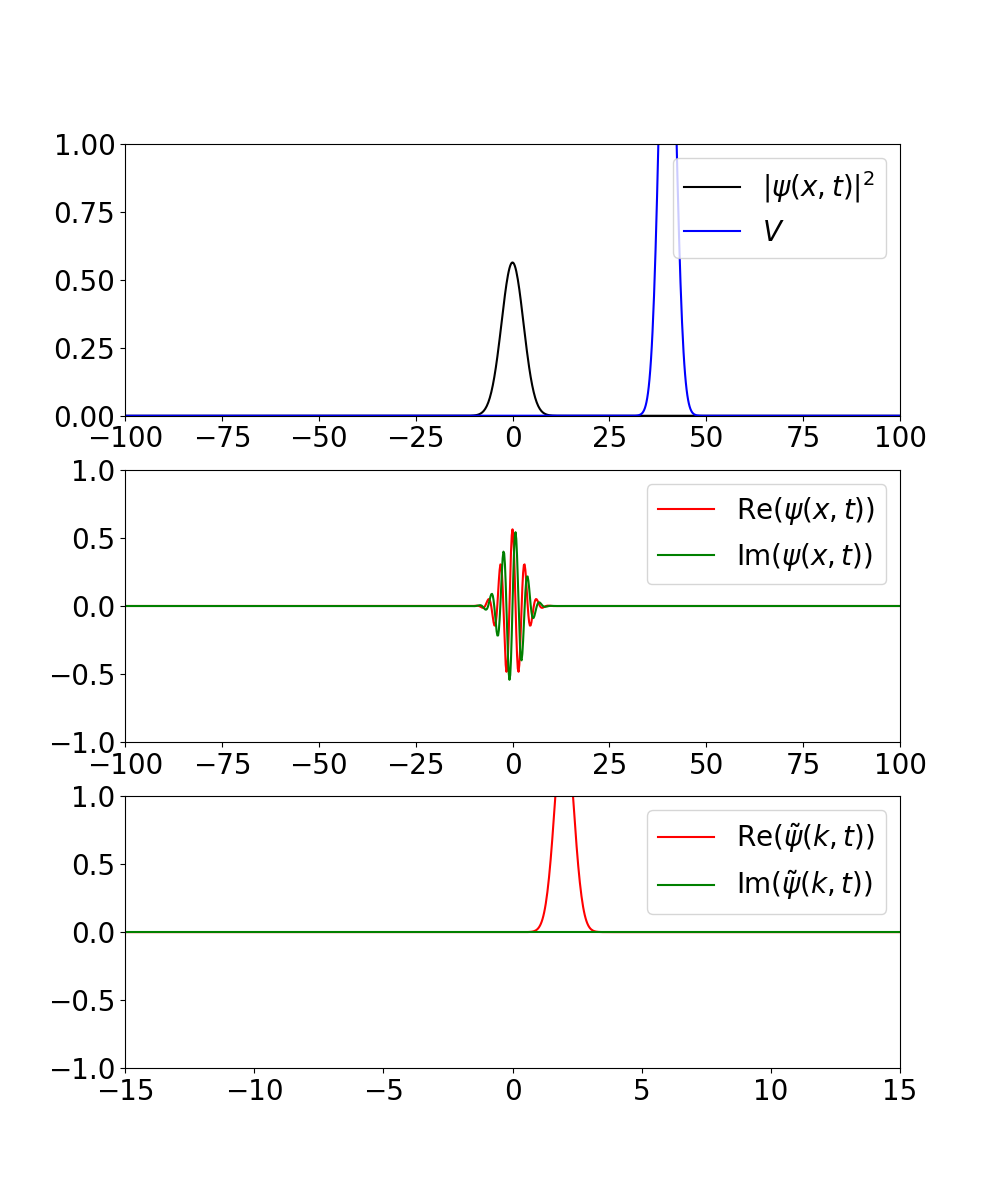

In [43]:
t=0

fig, axs = plt.subplots(3)
fig.set_size_inches(10, 12)

line1, = axs[0].plot(x_grid, rho_x[t], 'black', label='$|\psi(x,t)|^2$')
axs[0].plot(x_grid, potential, 'blue', label='$V$')

line2, = axs[1].plot(x_grid, np.real(psi_x[t]), 'red', label='Re($\psi(x,t)$)')
line3, = axs[1].plot(x_grid, np.imag(psi_x[t]), 'green', label='Im($\psi(x,t)$)')
        
line4, = axs[2].plot(k_grid, np.real(psi_k[t]), 'red', label='Re($\~\psi(k,t)$)')
line5, = axs[2].plot(k_grid, np.imag(psi_k[t]), 'green', label='Im($\~\psi(k,t)$)')

axs[0].set_xlim([-100, 100])
axs[1].set_xlim([-100, 100])
axs[2].set_xlim([-15, 15])

axs[0].set_ylim([0, 1])
axs[1].set_ylim([-1, 1])
axs[2].set_ylim([-1, 1])

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')

def change_time(time=0):
    line1.set_ydata(rho_x[time])
    line2.set_ydata(np.real(psi_x[time]))
    line3.set_ydata(np.imag(psi_x[time]))
    line4.set_ydata(np.real(psi_k[time]))
    line5.set_ydata(np.imag(psi_k[time]))
    
        
interact(change_time, time = widgets.IntSlider(min=0, max=Nt-1, step=1, value=0))